## Aufgabe 2
### Datenanalyse

In [28]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.conftest import axis
from scipy.stats import shapiro

In [3]:
# TODO Delete
DATA_DIR = Path("..", "data")
RAW, OUT = DATA_DIR / "raw", DATA_DIR / "processed"

In [33]:
df_nasdaq_daily_pp = pd.read_csv(OUT / "df_nasdaq_daily.csv", keep_default_na=False)
df_nasdaq_daily_pp["date"] = pd.to_datetime(df_nasdaq_daily_pp["date"])

df_nasdaq_weekly_pp = pd.read_csv(OUT / "df_nasdaq_weekly.csv", keep_default_na=False)

df_crypto_daily_pp = pd.read_csv(OUT / "df_crypto_daily.csv", keep_default_na=False)
df_crypto_daily_pp["date"] = pd.to_datetime(df_crypto_daily_pp["date"])

df_crypto_weekly_pp = pd.read_csv(OUT / "df_crypto_weekly.csv", keep_default_na=False)

df_nasdaq_meta_pp = pd.read_csv(OUT / "df_nasdaq_meta.csv", keep_default_na=False)

Average years of a company in NASDAQ: 11.325328939278425


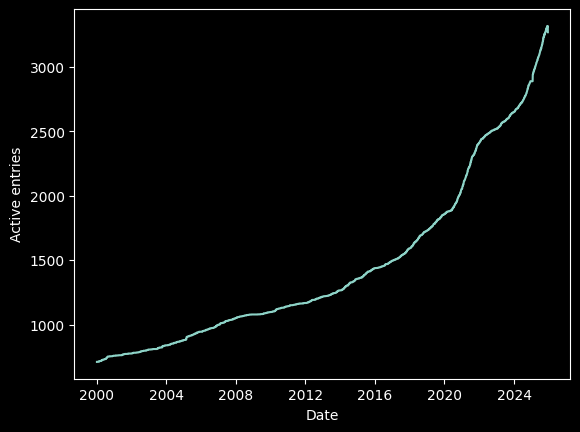

In [5]:
df_nasdaq_first_last = (df_nasdaq_daily_pp.groupby("ticker")["date"]
      .agg(firstdate="min", lastdate="max")
      .reset_index()
)

df_nasdaq_first_last["days"] = (df_nasdaq_first_last["lastdate"] - df_nasdaq_first_last["firstdate"]).dt.days
print("Average years of a company in NASDAQ:", df_nasdaq_first_last.days.mean() / 365)

dates_between = pd.date_range(
    df_nasdaq_first_last["firstdate"].min(),
    df_nasdaq_first_last["lastdate"].max(),
    freq='D'
)

# count active tickers per day
counts = pd.Series(dates_between).apply(lambda d: ((df_nasdaq_first_last.firstdate <= d) & (df_nasdaq_first_last.lastdate >= d)).sum())

plt.plot(dates_between, counts)
plt.xlabel('Date')
plt.ylabel('Active entries')
plt.show()

### NASDAQ Winning Shares per Year

In [24]:
df_nasdaq_yearly = df_nasdaq_daily_pp.copy()

df_nasdaq_yearly["year"] = df_nasdaq_yearly["date"].dt.year

df_nasdaq_yearly = (
    df_nasdaq_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_nasdaq_yearly["win"] = df_nasdaq_yearly["end"] > df_nasdaq_yearly["start"]
df_nasdaq_yearly["difference"] = df_nasdaq_yearly["end"] - df_nasdaq_yearly["start"]

s_wins_per_year = df_nasdaq_yearly.groupby("year")["win"].sum() / df_nasdaq_yearly.groupby("year")["ticker"].count()
s_difference_per_year = df_nasdaq_yearly.groupby("year")["difference"].sum() / df_nasdaq_yearly.groupby("year")["ticker"].count()

df_nasdaq_win = pd.DataFrame({"Winning Percentage": s_wins_per_year, "Avg Difference": s_difference_per_year})

bestyear = s_wins_per_year.idxmax()
print("Best Year (most companies won):", bestyear)

df_nasdaq_win

Best Year (most companies won): 2003


,Winning Percentage,AVG Win Sum
year,,
2000,0.377309,-3.840361e+07
2001,0.624516,-9.600858e+06
2002,0.408189,-1.509305e+06
2003,0.904648,4.208639e+05
2004,0.641638,-4.135585e+05
2005,0.393008,-7.900145e+03
2006,0.662325,-1.237195e+05
2007,0.392959,5.295232e+03
2008,0.138347,-1.121025e+07


### Crypto Winning Shares per Year

In [26]:
df_crypto_yearly = df_crypto_daily_pp.copy()

df_crypto_yearly["year"] = df_crypto_yearly["date"].dt.year

df_crypto_yearly = (
    df_crypto_yearly.groupby(["ticker", "year"])["close"]
      .agg(start="first", end="last")
      .reset_index()
)

df_crypto_yearly["win"] = df_crypto_yearly["end"] > df_crypto_yearly["start"]
df_crypto_yearly["difference"] = df_crypto_yearly["end"] - df_crypto_yearly["start"]

s_crypto_wins_per_year = df_crypto_yearly.groupby("year")["win"].sum() / df_crypto_yearly.groupby("year")["ticker"].count()
s_crypto_difference_per_year = df_crypto_yearly.groupby("year")["difference"].sum() / df_crypto_yearly.groupby("year")["ticker"].count()

df_crypto_win = pd.DataFrame({"Winning Percentage": s_crypto_wins_per_year, "Avg Difference": s_crypto_difference_per_year})

df_crypto_win

,Winning Percentage,AVG Win Sum
year,,
2010,1.000000,0.250490
2011,1.000000,4.420000
2012,1.000000,8.240000
2013,1.000000,406.595000
2014,0.333333,-172.936667
2015,0.500000,14.378754
2016,0.700000,-439.323666
2017,1.000000,710.814634
2018,0.111111,-408.081641


Man sieht, dass der durschnitttliche Gewinn der Cryptowährungen sich sehr stark ändert.
Im NASDAQ ist gut die Weltfinanzkrise 2008 und die "Corona-Jahre" zu erkennen, da hier die durchschnitlliche Kursänderung im Jahr stark ins Negative fällt

### Statistische Verteilung der Schlusskurse

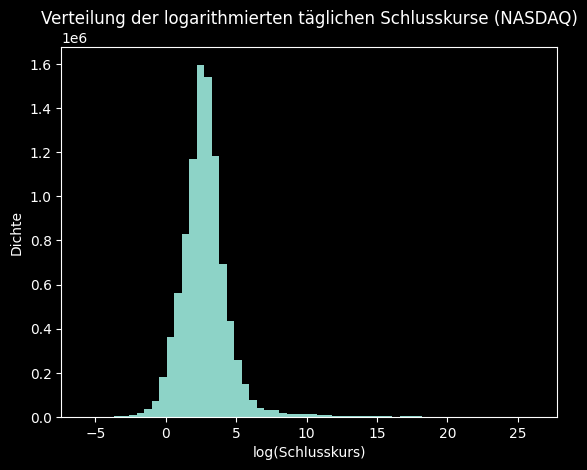

Shapiro-Wilk Statistik: 0.8978
p-Wert: 1.4224e-49


In [42]:
df_distribution = df_nasdaq_daily_pp.copy()

df_distribution["log_close"] = np.log(df_distribution["close"])

plt.hist(df_distribution["log_close"], bins=60)
plt.xlabel("log(Schlusskurs)")
plt.ylabel("Dichte")
plt.title("Verteilung der logarithmierten täglichen Schlusskurse (NASDAQ)")
plt.show()

# Achtung: Shapiro ist für sehr große n problematisch
sample = df_distribution["log_close"].sample(5000, random_state=42)

stat, p_value = shapiro(sample)

print(f"Shapiro-Wilk Statistik: {stat:.4f}")
print(f"p-Wert: {p_value:.4e}")

### Korelationsanalyse

In [74]:
BITCOIN = "BTC"
ETHEREUM = "ETH"
NVIDIA = "NVDA"
MICROSOFT = "MSFT"
AMAZON = "AMZN"
TESLA = "TSLA"

s_bitcoin = df_crypto_daily_pp.loc[df_crypto_daily_pp.ticker == BITCOIN][["date", "close"]].set_index("date")["close"]
s_bitcoin.name = BITCOIN

s_ethereum = df_crypto_daily_pp.loc[df_crypto_daily_pp.ticker == ETHEREUM][["date", "close"]].set_index("date")["close"]
s_ethereum.name = ETHEREUM

s_nvidia = df_nasdaq_daily_pp.loc[df_nasdaq_daily_pp.ticker == NVIDIA][["date", "close"]].set_index("date")["close"]
s_nvidia.name = NVIDIA

s_microsoft = df_nasdaq_daily_pp.loc[df_nasdaq_daily_pp.ticker == MICROSOFT][["date", "close"]].set_index("date")["close"]
s_microsoft.name = MICROSOFT

s_amazon = df_nasdaq_daily_pp.loc[df_nasdaq_daily_pp.ticker == AMAZON][["date", "close"]].set_index("date")["close"]
s_amazon.name = AMAZON

s_tesla = df_nasdaq_daily_pp.loc[df_nasdaq_daily_pp.ticker == TESLA][["date", "close"]].set_index("date")["close"]
s_tesla.name = TESLA

df_compare = pd.concat([s_bitcoin, s_ethereum, s_nvidia, s_microsoft, s_amazon, s_tesla], axis=1, join="inner")

df_compare.corr()


,BTC,ETH,NVDA,MSFT,AMZN,TSLA
BTC,1.000000,0.871972,0.915992,0.910686,0.880479,0.840560
ETH,0.871972,1.000000,0.727424,0.885953,0.830305,0.879838
NVDA,0.915992,0.727424,1.000000,0.859631,0.774252,0.700673
MSFT,0.910686,0.885953,0.859631,1.000000,0.925442,0.892361
AMZN,0.880479,0.830305,0.774252,0.925442,1.000000,0.859779
TSLA,0.840560,0.879838,0.700673,0.892361,0.859779,1.000000


### Renditen der Aktien
Es wird jeden Monat am ersten Tag 100€ in die jeweilige Aktie investiert

In [ ]:
"""df_nasdaq_rendite = (df_nasdaq_daily_pp
                     .loc[df_nasdaq_daily_pp.date >= START_DATE]
                     .groupby(["ticker"])["close"]
                     .agg(first="first", last="last"))

df_nasdaq_rendite["Rendite in %"] = ((df_nasdaq_rendite["last"] - df_nasdaq_rendite["first"]) / (df_nasdaq_rendite["first"]) * 100)"""
#TODO Delete

In [107]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_nasdaq_monthly = df_nasdaq_daily_pp.copy()
df_nasdaq_monthly["month"] = df_nasdaq_monthly["date"].dt.to_period("M")
df_nasdaq_monthly = (df_nasdaq_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_nasdaq_monthly["count"] = INVEST / df_nasdaq_monthly["close"]
print(df_nasdaq_monthly.head())

print("-------------------------------")

s_nasdaq_last = df_nasdaq_daily_pp.groupby(["ticker"])["close"].last()
s_nasdaq_last.name = "Last Value"
s_nasdaq_count = df_nasdaq_monthly.groupby(["ticker"])["count"].sum()
s_nasdaq_count.name = "Count"

df_nasdaq_rendite = pd.concat([s_nasdaq_last, s_nasdaq_count], axis=1)
df_nasdaq_rendite["Rendite"] = s_nasdaq_last * s_nasdaq_count

print(f"Höchste Rendite: {df_nasdaq_rendite["Rendite"].idxmax()} mit {df_nasdaq_rendite["Rendite"].max():.2f} €")

df_nasdaq_rendite


          month  close      count
ticker                           
AACB    2025-04   9.88  10.121457
AACB    2025-05   9.98  10.020040
AACB    2025-06  10.09   9.910803
AACB    2025-07  10.10   9.900990
AACB    2025-08  10.12   9.881423
-------------------------------
Höchste Rendite: NVDA mit 14069232.06 €


,Last Value,Count,Rendite
ticker,,,
AACB,10.3000,89.047121,917.185345
AACG,0.9419,36263.338485,34156.438519
AAL,14.9600,1842.635240,27565.823198
AAME,2.4800,14324.002427,35523.526019
AAOI,32.0600,1666.568869,53430.197954
...,...,...,...
ZURA,4.0200,1223.166586,4917.129677
ZVRA,8.3300,1253.013473,10437.602231
ZYBT,2.0100,279.706377,562.209818


In [108]:
START_DATE = pd.to_datetime("01.01.2020")
INVEST = 100    # in Euros

df_crypto_monthly = df_crypto_daily_pp.copy()
df_crypto_monthly["month"] = df_crypto_monthly["date"].dt.to_period("M")
df_crypto_monthly = (df_crypto_monthly
                     .groupby(["ticker", "month"])["close"]
                     .first()
                     .reset_index(["month"]))

df_crypto_monthly["count"] = INVEST / df_crypto_monthly["close"]
print(df_crypto_monthly.head())

print("-------------------------------")

s_crypto_last = df_crypto_daily_pp.groupby(["ticker"])["close"].last()
s_crypto_last.name = "Last Value"
s_crypto_count = df_crypto_monthly.groupby(["ticker"])["count"].sum()
s_crypto_count.name = "Count"

df_crypto_rendite = pd.concat([s_crypto_last, s_crypto_count], axis=1)
df_crypto_rendite["Rendite"] = s_crypto_last * s_crypto_count

print(f"Höchste Rendite: {df_crypto_rendite["Rendite"].idxmax()} mit {df_crypto_rendite["Rendite"].max():.2f} €")

df_crypto_rendite

          month  close      count
ticker                           
1INCH   2021-01  1.200  83.333333
1INCH   2021-02  5.053  19.790224
1INCH   2021-03  4.103  24.372410
1INCH   2021-04  4.448  22.482014
1INCH   2021-05  5.521  18.112661
-------------------------------
Höchste Rendite: BTC mit 803074653.66 €


,Last Value,Count,Rendite
ticker,,,
1INCH,0.170651,1.387854e+04,2368.387315
AAVE,192.117600,5.565610e+01,10692.515681
ADA,0.410623,6.384936e+04,26218.014849
ALGO,0.123037,3.154955e+04,3881.761564
AMP,0.002057,1.292610e+06,2658.898438
...,...,...,...
XRP,2.011100,4.202307e+05,845125.987737
XTZ,0.550165,8.118026e+03,4466.253649
YFI,3559.758000,8.704628e-01,3098.637049
